In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import socket, warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(("1.1.1.1", 53))
except socket.error as ex: raise Exception("STOP")

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('deer photos', max_images=1)

Searching for 'deer photos'


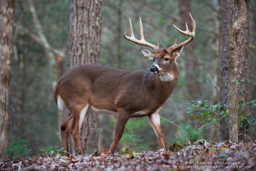

In [6]:
from fastdownload import download_url
dest = 'deer.jpg'
download_url(urls[0], dest, show_progress = False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


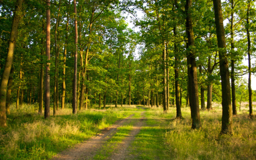

In [7]:
download_url(search_images('forest photos', max_images = 1)[0], 'forrest.jpg', show_progress=False)
Image.open('forrest.jpg').to_thumb(256,256)

In [8]:
searches = 'forest','deer'
path = Path('deer_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls = search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'deer photo'
Searching for 'deer sun photo'
Searching for 'deer shade photo'


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

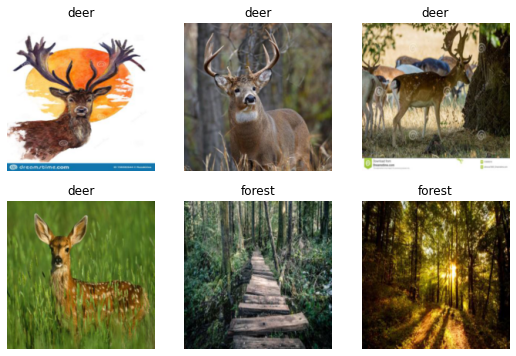

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2 , seed = 42),
    get_y=parent_label,
    item_tfms=[Resize(192, method = 'squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.987374,0.914591,0.352941,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.189386,0.079792,0.029412,00:01
1,0.108870,0.006718,0.000000,00:01
2,0.074309,0.015796,0.000000,00:01


In [12]:
is_deer,_,probs = learn.predict(PILImage.create('deer.jpg'))
print(f"This is a: {is_deer}.")
print(f"Probability it's a deer: {probs[0]:.4f}")

This is a: deer.
Probability it's a deer: 0.9999
